<h1 align="center">Classificação semi-supervisionada usando AutoEncoders </h1>

## Introdução

Por definição, o aprendizado de máquina pode ser definido como um processo complexo de aprender os melhores padrões, relacionamentos ou associações possíveis e mais relevantes de um conjunto de dados que pode ser usado para prever os resultados em dados não vistos. Em termos gerais, existem três processos diferentes de aprendizado de máquina:

** 1. Aprendizado supervisionado ** é um processo de treinamento de um modelo de aprendizado de máquina em um conjunto de dados rotulado, ou seja. um conjunto de dados no qual a variável de destino é conhecida. Nesta técnica, o modelo visa encontrar as relações entre a variável independente e dependente. Exemplos de aprendizado supervisionado são classificação, regressão e previsão.

** 2. O aprendizado não supervisionado ** é um processo de treinamento de um modelo de aprendizado de máquina em um conjunto de dados no qual a variável de destino não é conhecida. Nesta técnica, o modelo visa encontrar os padrões mais relevantes nos dados ou segmentos de dados. Exemplos de aprendizado não supervisionado são agrupamentos, segmentações, redução de dimensionalidade etc.

** 3 Aprendizado semi-supervisionado ** é uma combinação de processos de aprendizado supervisionado e não supervisionado, nos quais os dados não marcados também são usados ​​para treinar um modelo. Nesta abordagem, as propriedades do aprendizado não supervisionado são usadas para aprender a melhor representação possível dos dados e as propriedades do aprendizado supervisionado são usadas para aprender os relacionamentos nas representações que são usadas para fazer previsões.

<p align = "center"> Neste kernel, expliquei como executar tarefas de classificação usando a abordagem de aprendizado semi-supervisionado. Essa abordagem utiliza codificadores automáticos para aprender a representação dos dados; em seguida, um classificador linear simples é treinado para classificar o conjunto de dados nas respectivas classes.
 
<br>
<h1 align = "center"> Detecção de fraudes usando aprendizado semi-supervisionado </h1>

Estou usando o conjunto de dados de [Detecção de fraude de cartão de crédito] (https://www.kaggle.com/mlg-ulb/creditcardfraud) pelo grupo de aprendizado de máquina ULB. Mais tarde, também estou aplicando a mesma técnica no conjunto de dados [Titanic] (https://www.kaggle.com/c/titanic). Vários praticantes de kagglers compartilharam diferentes abordagens, como balanceamento de conjuntos de dados, detecção de anomalias, modelos de reforço, aprendizado profundo etc., mas essa abordagem é diferente.

### Conteúdo

1. Preparação do conjunto de dados
2. Visualize transações de fraude versus não fraude
3. AutoEncoders: Extração de Representação Latente
4. Obtenha as representações latentes
5. Visualize Representações Latentes: Fraude versus Não Fraude
6. Classificador Linear Simples

 
## 1. Preparação do conjunto de dados

Primeiro, carregaremos todas as bibliotecas necessárias e carregaremos o conjunto de dados usando o pandas dataframe.
 



In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
data = pd.read_csv("creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


O conjunto de dados consiste em 28 variáveis anônimas, 1 variável "quantidade", 1 variável "tempo" e 1 variável de destino - Classe. Vejamos a distribuição do alvo.

In [4]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


Um dos maiores desafios desse problema é que a meta ** é altamente desequilibrada **, pois apenas ** 0,17% ** são transações de fraude. Mas a vantagem da abordagem de aprendizado de representação é que ele ainda é capaz de lidar com a natureza de desequilíbrio dos problemas. Vamos ver como. Para o nosso caso de uso, tomemos apenas cerca de 1000 linhas de transações não fraudulentas.
## Considere apenas 1000 linhas de casos não fraudulentos

In [5]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

## 2. Visualize transações de fraude e não fraude

Vamos visualizar a natureza das transações fraudulentas e não fraudulentas usando o T-SNE. O T-SNE (incorporação estocástica de vizinhos distribuídos por t) é uma técnica de decomposição de conjunto de dados que reduz as dimensões dos dados e produz apenas os principais componentes com o máximo de informações.

Cada ponto a seguir representa uma transação. As transações não fraudulentas são representadas como verde, enquanto as transações fraudulentas são representadas como vermelho. Os dois eixos são os componentes extraídos pelo tsne.

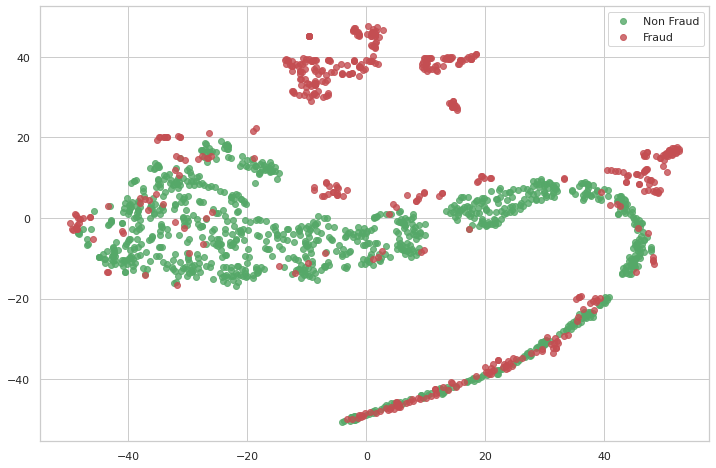

In [6]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

No gráfico acima, podemos observar que existem muitas transações não-fraudulentas muito próximas às transações fraudulentas, portanto, é difícil classificar com precisão a partir de um modelo.

## 3. AutoEncoders para o resgate

<br>
** O que são codificadores automáticos? ** - Os codificadores automáticos são um tipo especial de arquitetura de rede neural na qual a saída é igual à entrada. Os codificadores automáticos são treinados de maneira não supervisionada para aprender as representações de nível extremamente baixo dos dados de entrada. Esses recursos de baixo nível são então deformados de volta para projetar os dados reais. Um autoencoder é uma tarefa de regressão em que a rede é solicitada a prever sua entrada (em outras palavras, modelar a função de identidade). Essas redes possuem um forte gargalo de alguns neurônios no meio, forçando-os a criar representações efetivas que comprimem a entrada em um código de baixa dimensão que pode ser usado pelo decodificador para reproduzir a entrada original.

** Mais sobre codificadores automáticos ** - Se você quiser obter mais entendimento sobre codificadores automáticos, consulte o seguinte kernel: https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

![](https://i.imgur.com/Rrmaise.png)

Criaremos um modelo de codificador automático no qual mostramos apenas os casos de não fraude do modelo. O modelo tentará aprender a melhor representação de casos não fraudulentos. O mesmo modelo será usado para gerar as representações de casos de fraude e esperamos que sejam diferentes dos casos de não fraude.

Crie uma rede com uma camada de entrada e uma camada de saída com dimensões idênticas, ou seja. a forma dos casos não fraudulentos. Vamos usar o pacote keras.

In [7]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Crie a arquitetura do modelo compilando as camadas de entrada e saída. Adicione também a função otimizador e perda, estou usando "adadelta" como otimizador e "mse" como função de perda.

In [8]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Antes do treinamento, vamos realizar o dimensionamento mínimo e máximo.

In [9]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

A vantagem dessa abordagem é que não precisamos de muitas amostras de dados para aprender as boas representações. Usaremos ** apenas 2000 linhas ** de casos não fraudulentos para treinar o codificador automático. Além disso, não precisamos executar esse modelo para um grande número de épocas.

** Explicação: ** A escolha de pequenas amostras do conjunto de dados original é baseada na intuição de que as características de uma classe (não fraude) serão diferentes das da outra (fraude). Para distinguir essas características, precisamos mostrar aos auto-codificadores apenas uma classe de dados. Isso ocorre porque o codificador automático tenta aprender apenas uma classe e distingue automaticamente a outra classe. 

In [10]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 0s 24ms/step - loss: 0.2386 - val_loss: 0.2379
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2382 - val_loss: 0.2376
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2379 - val_loss: 0.2372
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2375 - val_loss: 0.2368
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2371 - val_loss: 0.2364
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2367 - val_loss: 0.2360
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2363 - val_loss: 0.2356
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2359 - val_loss: 0.2353
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2356 - val_loss: 0.2349
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2352 - val_loss: 0.2345




## 4. Obtenha as representações latentes

Agora, o modelo está treinado. Estamos interessados em obter ** representação latente da entrada ** aprendida pelo modelo. Isso pode ser acessado pelos pesos do modelo treinado. Criaremos outra rede contendo camadas seqüenciais e adicionaremos apenas os pesos treinados até a terceira camada em que existe representação latente.

In [11]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Gere as representações ocultas de duas classes: não-fraude e fraude, prevendo as entradas brutas usando o modelo acima.

In [12]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

## 5. Visualize as representações latentes: Fraude versus Não Fraude

Agora, criaremos um conjunto de dados de treinamento usando as representações latentes obtidas e vamos visualizar a natureza dos casos de fraude versus não-fraude.

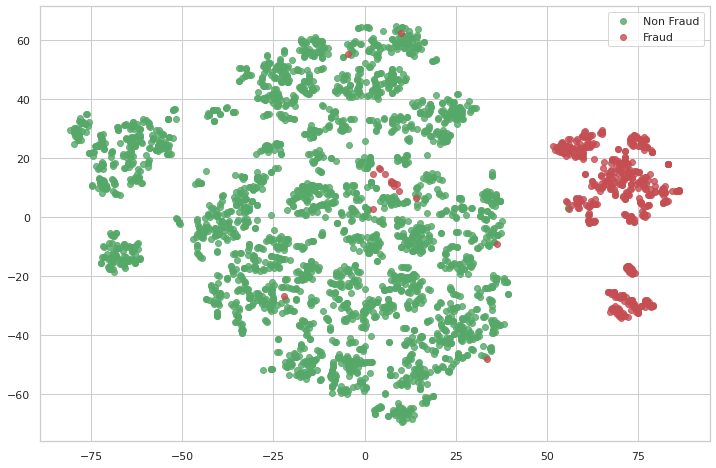

In [13]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

Que gráfico perfeito, podemos observar que agora as transações de fraude e não fraude são bastante visíveis e são linearmente separáveis. Agora não precisamos de nenhum modelo complexo para classificar isso, mesmo os modelos mais simples podem ser usados para prever. Aqui está a visão antes e depois das transações de fraude e não fraude.

In [14]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


Agora, podemos apenas treinar um classificador linear simples no conjunto de dados.

## 6. Classificador linear simples

In [15]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.90      0.95       131

    accuracy                           0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.98       873


Accuracy Score:  0.9851088201603666
